# The charging station

`pyspect` can set up problems independently from implementations...
At this stage, we only need to import pyspect and select a pyspect language...

In [2]:
import sys
import os

# Get the path to the parent folder of 'examples' (i.e., the 'pyscept' folder)
parent_dir = os.path.abspath(os.path.join(os.getcwd(), ".."))

# Add the 'src' directory to Python's search path
src_path = os.path.join(parent_dir, "src")
sys.path.append(src_path)



from math import pi

from pyspect import *
from pyspect.langs.ltl import *

TLT.select(ContinuousLTL)

## Environment

Let us first setup the 4-way intersection environment...

In [185]:
## CONSTANTS ##

# Define origin and size of area, makes it easier to scale up/down later on 
X0, XN = -2, 4
Y0, YN = -2, 4

STATE_INIT = [X0+7.5*XN/8, Y0+2.5*YN/8, pi, 0]

Speedlimit bound

In [4]:
## TRAFFIC RULES ##

speedlimit = BoundedSet(v=(0.3, 0.6))

Setting up bounds

In [5]:
## ROADS ##

# space = BoundedSet(x=(X0, X0 + XN), y=(Y0, Y0 + YN))

intersection = And(
    BoundedSet(x=(X0, X0 + 0.25*XN), y=(Y0 + 0.125*YN, Y0 + 0.375*YN)),
    speedlimit
)

road_n = BoundedSet(x=(X0 + 0.125*XN, X0 + 0.25*XN), h=(+pi/2 - pi/5, +pi/2 + pi/5))
# road_n = BoundedSet(x=(X0 + 0.125*XN, X0 + 0.25*XN))
road_n = Or(And(road_n, speedlimit), intersection)

road_s = BoundedSet(x=(X0, X0 + 0.125*XN), h=(-pi/2 - pi/5, -pi/2 + pi/5))
# road_s = BoundedSet(x=(X0, X0 + 0.125*XN))
road_s = Or(road_s, intersection)

exit_n = And(BoundedSet(x=(X0 + 0.125*XN, X0 + 0.25*XN), y=(Y0 + 0.875*YN, Y0 + YN)), road_n)
exit_s = And(BoundedSet(x=(X0, X0 + 0.125*XN), y=(Y0, Y0 + 0.125 * YN)), road_s)
# exit_s = BoundedSet(x=(X0, X0 + 0.1*XN), y=(Y0, Y0 + 0.1 * YN))

## PARKING LOT ##

parking_lot = Or(
    BoundedSet(x=(X0 + 0.25*XN, X0 + 0.375*XN), y=(Y0 + 1*YN/8, Y0 + 3*YN/8)),  # Entry/Exit
    BoundedSet(x=(X0 + 0.375*XN, X0 + XN), y=(Y0, Y0 + 0.5*YN))                     # Main box
)

parking_space_1 = BoundedSet(x=(X0 + 0.875*XN, X0 + XN), y=(Y0, Y0 + 0.125*YN))
parking_space_2 = BoundedSet(x=(X0 + 0.875*XN, X0 + XN), y=(Y0 + 0.125*YN, Y0 + 0.25*YN))
parking_space_3 = BoundedSet(x=(X0 + 0.875*XN, X0 + XN), y=(Y0 + 0.25*YN, Y0 + 0.375*YN))

In [6]:
def FollowTo(constraint, goal_or_constraint, *more):
    if more: # 2nd arg is constraint
        return FollowTo(And(constraint, goal_or_constraint), *more)
    else: # 2nd arg is exit
        return Until(constraint, goal_or_constraint)

Three vehicles in the scenario must follow these rules...

In [7]:
vehicle_1 = FollowTo(Or(road_s, road_n, parking_lot), exit_n)

# vehicle_2 = FollowTo(road_n, Not(vehicle_1), exit_n)

# vehicle_3 = FollowTo(road_e, Not(vehicle_1), Not(vehicle_2), exit_e)

Implementation using `hj_reachability`.

In [8]:
import numpy as np
import hj_reachability as hj

class HJImpl(ContinuousLTL.Impl):

    solver_settings = hj.SolverSettings.with_accuracy("low")

    def __init__(self, dynamics, grid, time_horizon):
        self.grid = grid
        self.ndim = grid.ndim
        self.dynamics = dynamics
        self.timeline = self.new_timeline(time_horizon)
           
    def new_timeline(self, target_time, start_time=0, time_step=0.2):
        assert time_step > 0
        is_forward = target_time >= start_time
        target_time += 1e-5 if is_forward else -1e-5
        time_step *= 1 if is_forward else -1
        return np.arange(start_time, target_time, time_step)

    def set_axes_names(self, *args):
        assert len(args) == self.ndim
        self._axes_names = tuple(args)

    def axis(self, name: str) -> int:
        assert name in self._axes_names, f'Axis ({name=}) does not exist.'
        return self._axes_names.index(name)

    def axis_name(self, i: int) -> str:
        assert i < len(self._axes_names), f'Axis ({i=}) does not exist.'
        return self._axes_names[i]

    def axis_is_periodic(self, i: int) -> bool:
        assert i < len(self._axes_names), f'Axis ({i=}) does not exist.'
        return bool(self.grid._is_periodic_dim[i])

    def plane_cut(self, normal, offset, axes=None):
        data = np.zeros(self.grid.shape)
        axes = axes or list(range(self.grid.ndim))
        x = lambda i: self.grid.states[..., i]
        for i, k, m in zip(axes, normal, offset):
            data -= k*x(i) - k*m
        return data

    def empty(self):
        return np.ones(self.grid.shape)*np.inf
    
    def complement(self, vf):
        return np.asarray(-vf)
    
    def intersect(self, vf1, vf2):
        return np.maximum(vf1, vf2)

    def union(self, vf1, vf2):
        return np.minimum(vf1, vf2)
    
    def reach(self, target, constraints=None):
        self.dynamics.with_mode('reach')
        if not self.is_invariant(target):
            target = np.flip(target, axis=0)
        if not self.is_invariant(constraints):
            constraints = np.flip(constraints, axis=0)
        vf = hj.solve(self.solver_settings,
                      self.dynamics,
                      self.grid,
                      -self.timeline,
                      target,
                      constraints)
        return np.flip(np.asarray(vf), axis=0)
    
    def avoid(self, target, constraints=None):
        self.dynamics.with_mode('avoid')
        if not self.is_invariant(target):
            target = np.flip(target, axis=0)
        if not self.is_invariant(constraints):
            constraints = np.flip(constraints, axis=0)
        vf = hj.solve(self.solver_settings,
                      self.dynamics,
                      self.grid,
                      -self.timeline,
                      target,
                      constraints)
        return np.flip(np.asarray(vf), axis=0)

    def project_onto(self, vf, *idxs, keepdims=False, union=True):
        idxs = [len(vf.shape) + i if i < 0 else i for i in idxs]
        dims = [i for i in range(len(vf.shape)) if i not in idxs]
        if union:
            return vf.min(axis=tuple(dims), keepdims=keepdims)
        else:
            return vf.max(axis=tuple(dims), keepdims=keepdims)

    def is_invariant(self, vf):
        return (True if vf is None else
                len(vf.shape) != len(self.timeline.shape + self.grid.shape))

    def make_tube(self, vf):
        return (vf if not self.is_invariant(vf) else
                np.concatenate([vf[np.newaxis, ...]] * len(self.timeline)))

In [147]:
from hj_reachability.systems import Bicycle4D
from pyspect.plotting.levelsets import *

reach_dynamics = Bicycle4D(min_steer=-5*pi/4,
                           max_steer=+5*pi/4,
                           min_accel=-0.4,
                           max_accel=+0.4)

min_bounds = np.array([   X0,    Y0, -pi, +0.3])
max_bounds = np.array([XN+X0, YN+Y0, +pi, +0.8])
grid = hj.Grid.from_lattice_parameters_and_boundary_conditions(hj.sets.Box(min_bounds, max_bounds),
                                                               (31, 31, 25, 7),
                                                               periodic_dims=2)

impl = HJImpl(reach_dynamics, grid, 15)
impl.set_axes_names('x', 'y', 'h', 'v')

out1 = TLT.construct(vehicle_1).realize(impl)
# out2 = TLT.construct(vehicle_2).realize(impl)
# out3 = TLT.construct(vehicle_3).realize(impl)

100%|##########| 15.0000/15.0 [00:35<00:00,  2.34s/sim_s]


In [217]:
plot3D_levelset(impl.project_onto(out1, 0, 1, 2),
                min_bounds=[0, *min_bounds[:2]],
                max_bounds=[15, *max_bounds[:2]])

# plot3D_levelset(impl.project_onto(out1, 0, 3, 4),
#                 min_bounds=[0, *min_bounds[2:4]],
#                 max_bounds=[10, *max_bounds[2:4]])

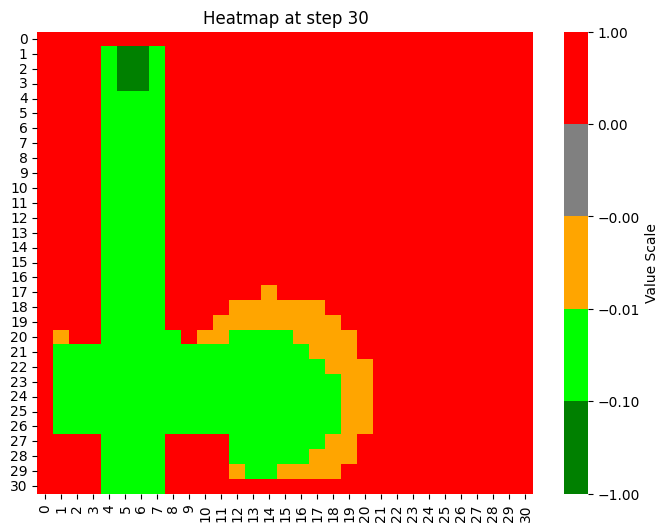

In [250]:
### HEAT-MAP ###

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, BoundaryNorm
import seaborn as sns

# Example: Create a matrix of arrays

t = 30
out1_heat_pos = np.rot90(out1[t].min(axis=(2,3)))

# Create a custom colormap where 0 is gray and other values use coolwarm
colors = ["green","lime", "orange", "gray", "red"]  # Include gray for 0
cmap = ListedColormap(colors)

# Define boundaries to control the color mapping
bounds = [-1,-0.1,-0.01, -1e-5, 0, 1]  # Ensure 0 is within its own boundary
norm = BoundaryNorm(bounds, cmap.N)

# Plot the heatmap
plt.figure(figsize=(8, 6))
heatmap = sns.heatmap(out1_heat_pos, cmap=cmap, norm=norm, cbar_kws={'ticks': bounds, 'label': 'Value Scale'})

plt.title("Heatmap at step "+str(t))
plt.show()

(31, 31) (31, 31)
-0.13333336


C:\Users\lukas\AppData\Local\Temp\ipykernel_13552\1078934930.py:42: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)

C:\Users\lukas\AppData\Local\Temp\ipykernel_13552\1078934930.py:43: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)



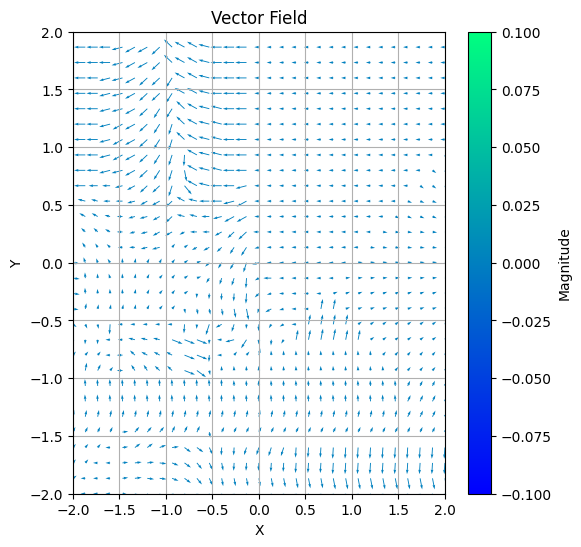

In [246]:
### VECTOR FIELD (whole area) ###

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, BoundaryNorm
import seaborn as sns


# Create a custom colormap where 0 is gray and other values use coolwarm
colors = ["lime", "gray", "red"]  # Include gray for 0
cmap = ListedColormap(colors)

# Define boundaries to control the color mapping
bounds = [-1,-1e-5, 0, 1]  # Ensure 0 is within its own boundary
norm = BoundaryNorm(bounds, cmap.N)


# Define grid
x, y = np.meshgrid(np.linspace(X0, X0+XN, 31), np.linspace(Y0, Y0+YN, 31))
print(np.shape(x),np.shape(y))

u = np.zeros(np.shape(x))
v = np.zeros(np.shape(y))

value_array = np.zeros(np.shape(x))

t = 0


for row in range(len(out1[t,0,:,0,0])):
    for col in range(len(out1[t,:,0,0,0])):
        
        min_value = np.min(out1[0,col,row,:,:])
        min_index = np.where(out1[0,col,row,:,:] == min_value)
        if np.shape(min_index) != (2, 1):
            ind_theta = min_index[0][0]
            ind_v = min_index[1][0]
            
        else:
            ind_theta, ind_v = min_index

        u[col,row] = (0.3 + 0.5*ind_v/7) * np.cos((-1 + 2*ind_theta/25) * np.pi)
        v[col,row] = (0.3 + 0.5*ind_v/7) * np.sin((-1 + 2*ind_theta/25) * np.pi)

        # value_array[col,row] = -1 * len(min_index[0])
        # print(len(min_index[0]))
        value_array[col,row] = min(value_array[col,row],1e-5)
        # print(u[col,row],v[col,row])

print(np.min(out1[t]))
# print(out1[t,:,:,:,:])
# Plot vector field
plt.figure(figsize=(6,6))
plt.quiver(x, y, u, v, value_array, cmap="winter")

# Show plot
plt.xlabel("X")
plt.ylabel("Y")
plt.title("Vector Field")
plt.colorbar(label="Magnitude")
plt.xlim([-2,2])
plt.ylim([-2,2])
plt.grid()
plt.show()


28 2


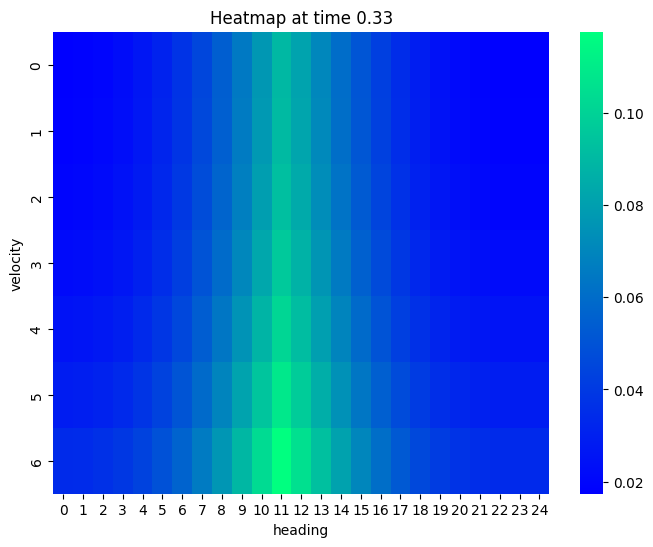

In [248]:
### HEAT MAP (from specific point) ###

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, BoundaryNorm
import seaborn as sns

# Example: Create a matrix of arrays

t = 25
# x_init = STATE_INIT[0]
# y_init = STATE_INIT[1]
x_init = X0 + 7.5*XN/8
y_init = Y0 + 0.5*YN/8
dx = XN / 30
dy = YN / 30
ind_x_init = round((x_init - X0)/dx)
ind_y_init = round((y_init - Y0)/dy)

print(ind_x_init,ind_y_init)

out1_heat_pos = np.rot90(out1[t,ind_x_init,ind_y_init,:,:])
# print(out1_heat_pos)

# Plot the heatmap
plt.figure(figsize=(8, 6))
heatmap = sns.heatmap(out1_heat_pos, cmap="winter")

plt.title("Heatmap at time "+str(round(t/len(out1), 2)))
plt.xlabel("heading")
plt.ylabel("velocity")
# plt.scatter([0],[0],s=100,color="black")
plt.show()

Optimization of unconstrained problem with casadi (doesn't handle MINLP)

In [221]:
### MPC WITHOUT WARM-STARTING, GOAL IS A POINT ###

import casadi as ca

# Parameters
L = 0.8  # Wheelbase of the vehicle
dt = 0.2  # Time step (s)
N = 30  # Prediction horizon

# Define the bicycle model dynamics
def bicycle_dynamics(state, control):
    """
    Bicycle model dynamics with CasADi-compatible indexing.
    state = [x, y, v, theta]
    control = [a, delta]
    """
    x = state[0]
    y = state[1]
    v = state[2]
    theta = state[3]
    a = control[0]
    delta = control[1]

    # Compute the state derivatives
    dx = v * ca.cos(theta)
    dy = v * ca.sin(theta)
    dv = a
    dtheta = v / L * ca.tan(delta)
    
    return ca.vertcat(dx, dy, dv, dtheta)  # Return as a vertical concatenation


# MPC setup
opti = ca.Opti()  # Create optimization problem

# State and control variables
X = opti.variable(4, N + 1)  # State trajectory [x, y, v, theta]
U = opti.variable(2, N)  # Control inputs [a, delta]
x0 = opti.parameter(4)  # Initial state [x, y, v, theta]
x_goal = opti.parameter(2)  # Goal state [x, y]


# Cost function
cost = 0
Q = 0
Q_T = 1e10
R = 1
for t in range(N):
    # Tracking cost: minimize distance to goal
    # cost += Q * ca.sumsqr(X[[0,1], t] - x_goal)
    
    # Control effort cost: minimize acceleration and steering
    cost += R * ca.sumsqr(U[0, t])

# Terminal cost (final state close to goal)
cost += Q_T * ca.sumsqr(X[[0,1], N] - x_goal)

### Constraints

# Bounds on state
bounds_X = np.array([[X0,Y0,0.0,-np.pi],
                [X0+XN,Y0+YN,0.8,np.pi]])
bounds_U = np.array([[-0.4, -5*np.pi],
                     [0.4, 5*np.pi]])

for i in range(4):
    opti.subject_to(X[i, :] >= bounds_X[0,i])
    opti.subject_to(X[i, :] <= bounds_X[1,i])
for i in range(2):
    opti.subject_to(U[i, :] >= bounds_U[0,i])
    opti.subject_to(U[i, :] <= bounds_U[1,i])


# Dynamics
opti.subject_to(X[:, 0] == x0)  # Initial state constraint
for t in range(N):
    # System dynamics constraint
    opti.subject_to(X[:, t + 1] == X[:, t] + dt * bicycle_dynamics(X[:, t], U[:, t]))

# Obstacles
obst_list = []
obst_rad = 1/15 * XN

for y in range(3,8):
    obst_list.append([X0+2.5*XN/8, Y0+(y+0.5)*YN/8])

for x in range(3,8):
    obst_list.append([X0+(x+0.5)*XN/8, Y0+4.5*YN/8])

obst_list.append([X0+2.5*XN/8, Y0+0.5*YN/8])

for ob in obst_list:
    opti.subject_to((X[0,:] - ob[0])**2 + (X[1,:] - ob[1])**2 >= obst_rad**2)

# Solver settings
opti.minimize(cost)
opti.solver('ipopt', {
    "print_time": 0,  # Suppress IPOPT solver output
    "ipopt.print_level": 0
})

# Simulation setup
T = 10  # Total simulation steps
x_init = np.array([X0+7.5*XN/8, Y0+2.5*YN/8, 0, np.pi])  # Start state [x, y, v, theta]
goal = np.array([X0+1.5*XN/8, Y0+7.5*YN/8])  # Goal state [x, y, v, theta]

# Store trajectory
# trajectory = [x_init]
# for _ in range(T):
    # Set the current state and goal
    # opti.set_value(x0, x_init)
    # opti.set_value(x_goal, goal)
    
    # # Solve the optimization problem
    # sol = opti.solve()
    
    # # Extract control and apply the first input
    # u_opt = sol.value(U[:, 0])
    # x_next = sol.value(X[:, 1])
    
    # # Update the state and store it
    # x_init = x_next
    # trajectory.append(x_next)

opti.set_value(x0, x_init)
opti.set_value(x_goal, goal)
sol = opti.solve()

trajectory = sol.value(X)
    
# Solve the optimization problem
sol = opti.solve()

# Convert trajectory to a numpy array for plotting
trajectory = np.array(trajectory)

# print(trajectory)

In [244]:
### MPC WITHOUT WARM-STARTING, GOAL IS ROAD,VEL;STEER ###

import casadi as ca

# Parameters
L = 0.8  # Wheelbase of the vehicle
dt = 0.2  # Time step (s)
N = 50  # Prediction horizon

# Define the bicycle model dynamics
def bicycle_dynamics(state, control):
    """
    Bicycle model dynamics with CasADi-compatible indexing.
    state = [x, y, v, theta]
    control = [a, delta]
    """
    x = state[0]
    y = state[1]
    v = state[2]
    theta = state[3]
    a = control[0]
    delta = control[1]

    # Compute the state derivatives
    dx = v * ca.cos(theta)
    dy = v * ca.sin(theta)
    dv = a
    dtheta = v / L * ca.tan(delta)
    
    return ca.vertcat(dx, dy, dv, dtheta)  # Return as a vertical concatenation


# MPC setup
opti = ca.Opti()  # Create optimization problem

# State and control variables
X = opti.variable(4, N + 1)  # State trajectory [x, y, v, theta]
U = opti.variable(2, N)  # Control inputs [a, delta]
x0 = opti.parameter(4)  # Initial state [x, y, v, theta]
x_goal = opti.parameter(1)  # Goal state [x, y]


# Cost function
cost = 0
Q = 1
Q_T = Q
R = 1
for t in range(N):
    # Tracking cost: minimize distance to road
    cost += Q * ca.sumsqr(X[[0], t] - x_goal)
    
    # Control effort cost: minimize acceleration and steering
    cost += R * ca.sumsqr(U[0, t])

# Terminal cost (final state close to goal)
cost += Q_T * ca.sumsqr(X[[0], N] - x_goal)

### Constraints

# Bounds on state
bounds_X = np.array([[X0,Y0,0.0,-np.pi],
                [X0+XN,Y0+YN+np.inf,0.8,np.pi]])
bounds_U = np.array([[-0.4, -5*np.pi],
                     [0.4, 5*np.pi]])

for i in range(4):
    opti.subject_to(X[i, :] >= bounds_X[0,i])
    opti.subject_to(X[i, :] <= bounds_X[1,i])
for i in range(2):
    opti.subject_to(U[i, :] >= bounds_U[0,i])
    opti.subject_to(U[i, :] <= bounds_U[1,i])

# opti.subject_to(X[0, N] == x_goal)
opti.subject_to(X[2, N] == 0.5)
opti.subject_to(X[3, N] == np.pi/2)



# Dynamics
opti.subject_to(X[:, 0] == x0)  # Initial state constraint
for t in range(N):
    # System dynamics constraint
    opti.subject_to(X[:, t + 1] == X[:, t] + dt * bicycle_dynamics(X[:, t], U[:, t]))

# Obstacles
obst_list = []
obst_rad = 1/12 * XN

for y in range(3,8):
    obst_list.append([X0+2.5*XN/8, Y0+(y+0.5)*YN/8])

for x in range(3,8):
    obst_list.append([X0+(x+0.5)*XN/8, Y0+4.5*YN/8])

obst_list.append([X0+2.5*XN/8, Y0+0.5*YN/8])

for ob in obst_list:
    opti.subject_to((X[0,:] - ob[0])**2 + (X[1,:] - ob[1])**2 >= obst_rad**2)


# Solver settings
opti.minimize(cost)
opti.solver('ipopt', {
    "print_time": 0,  # Suppress IPOPT solver output
    "ipopt.print_level": 0
})

# Simulation setup
T = 10  # Total simulation steps
x_init = np.array([X0+7.5*XN/8, Y0+2.5*YN/8, 0, np.pi])  # Start state [x, y, v, theta]
goal = np.array([X0+1.5*XN/8])  # Goal state [x, y, v, theta]

# Warm start

points = np.linspace(x_init[0],goal,N+1)
# opti.set_initial(X[0,:],points[:])

opti.set_value(x0, x_init)
opti.set_value(x_goal, goal)
sol = opti.solve()

trajectory = sol.value(X)
    
# Solve the optimization problem
sol = opti.solve()

# Convert trajectory to a numpy array for plotting
trajectory = np.array(trajectory)

# print(trajectory)

In [112]:
opti.debug.value(X)

array([[ 1.75000000e+00,  1.75000000e+00,  1.74636364e+00,
         1.73916514e+00,  1.72847869e+00,  1.71437852e+00,
         1.69693884e+00,  1.67623384e+00,  1.65233776e+00,
         1.62532479e+00,  1.59526914e+00,  1.56224504e+00,
         1.52632669e+00,  1.48758830e+00,  1.44610408e+00,
         1.40194825e+00,  1.35519501e+00,  1.30591859e+00,
         1.25419318e+00,  1.20009300e+00,  1.14369227e+00,
         1.08506519e+00,  1.02428597e+00,  9.61428835e-01,
         8.96567985e-01,  8.29777634e-01,  7.61131994e-01,
         6.90705277e-01,  6.18571695e-01,  5.44805458e-01,
         4.69480778e-01,  3.92671867e-01,  3.14452936e-01,
         2.34898197e-01,  1.54081861e-01,  7.20781406e-02,
        -1.10387534e-02, -9.51946093e-02, -1.80315216e-01,
        -2.66326361e-01, -3.53153833e-01, -4.40723420e-01,
        -5.28960912e-01, -6.17792096e-01, -7.07142761e-01,
        -7.96938695e-01, -8.87105687e-01, -9.77569525e-01,
        -1.06825600e+00, -1.15909089e+00, -1.25000000e+0

C:\Users\lukas\AppData\Local\Temp\ipykernel_13552\4223567421.py:19: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.



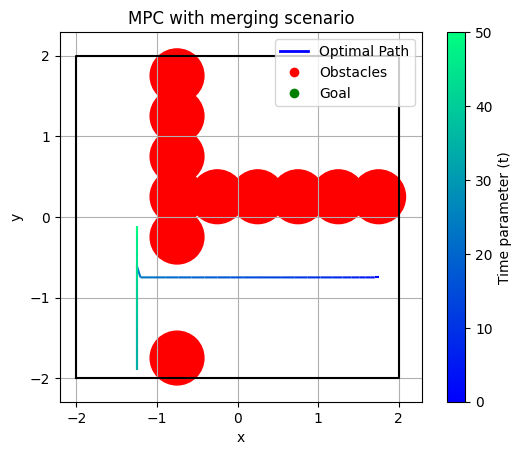

In [245]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.cm as cm
from matplotlib.collections import LineCollection
from matplotlib.lines import Line2D
import matplotlib.patches as patches

# Define the line points
t = np.linspace(0, N, N+1)  # Time or parameter for the line
x = trajectory[0, :]  # X-coordinates
y = trajectory[1, :]  # Y-coordinates

# Create segments for gradient effect
points = np.array([x, y]).T.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1)

# Define colormap (from blue to green)
cmap = cm.get_cmap("winter")  # 'winter' is a built-in blue-to-green colormap
norm = plt.Normalize(t.min(), t.max())  # Normalize colors based on t

# Create a LineCollection with colors
lc = LineCollection(segments, cmap=cmap, norm=norm)
lc.set_array(t)  # Use t to define color transition

# Plot
fig, ax = plt.subplots()
ax.add_collection(lc)
ax.set_aspect('equal')  # Keep axis scale proportional

# Add colorbar
cb = plt.colorbar(lc, ax=ax)
cb.set_label("Time parameter (t)")

# Plot goal
# ax.scatter(goal[0], goal[1], color='green', label='Goal')
# ax.add_patch(patches.Circle((goal[0], goal[1]), obst_rad/2, color='green'))

# Plot obstacles (large dots on the plot)
for obst in obst_list:
    ax.add_patch(patches.Circle((obst[0], obst[1]), obst_rad, color='red'))

# Add box
ax.plot([X0, X0, X0+XN, X0+XN, X0], [Y0, Y0+YN, Y0+YN, Y0, Y0], color='black')

# Fix labels
plt.xlabel('x')
plt.ylabel('y')
plt.title('MPC with merging scenario')

# Create custom legend entries
line_legend = Line2D([0], [0], color='blue', lw=2, label='Optimal Path')
obstacle_legend = Line2D([0], [0], marker='o', color='w', markersize=8, 
                         markerfacecolor='red', label='Obstacles')
goal_legend = Line2D([0], [0], marker='o', color='w', markersize=8, 
                      markerfacecolor='green', label='Goal')

ax.legend(handles=[line_legend, obstacle_legend, goal_legend], loc='upper right')

ax.grid(True)
plt.show()


Optimization with cplex

In [129]:
# # first import the Model class from docplex.mp
# from docplex.mp.model import Model
# import math
# import numpy as np

# L = 1

# # create one model instance, with a name
# m = Model(name='Merging_scenario')

# # by default, all variables in Docplex have a lower bound of 0 and infinite upper bound
# x = m.continuous_var(name='x')
# y = m.continuous_var(name='y')
# v = m.continuous_var(name='v')
# theta = m.continuous_var(name='theta')

# cos_theta = 1-theta**2/2
# sin_theta = theta
# tan_delta = theta

# a = m.continuous_var(name='a')
# delta = m.continuous_var(name='delta')

# state = [x,y,v,theta]
# input = [a,delta]

# xdot = [v*cos_theta,v*sin_theta,a,v/L*tan_delta]


# # constraint #3: assembly time limit
# ct_assembly = m.add_constraint(x**2 <= 400)
# ct_assembly = m.add_constraint(y**2 <= x)

# # constraint #4: paiting time limit
# # ct_painting = m.add_constraint( 0.5 * desk + 0.4 * cell <= 490)

# m.maximize(state[0] + state[1])

# m.print_information()

# s = m.solve()
# m.print_solution()